In [55]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import pickle
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)


# load train dataset
trainX, trainy = load_dataset('dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('dataset/val/')
# save arrays to one file in compressed format
savez_compressed('dataset.npz', trainX, trainy, testX, testy)

>loaded 10 examples for class: George_HW_Bush
>loaded 5 examples for class: Jose_Luis
>loaded 7 examples for class: Leonardo_DiCaprio
>loaded 12 examples for class: Meryl_Streep
>loaded 9 examples for class: Michael_Jackson
>loaded 5 examples for class: Patricia
>loaded 41 examples for class: Unknown
(89, 160, 160, 3) (89,)
>loaded 3 examples for class: George_HW_Bush
>loaded 3 examples for class: Jose_Luis
>loaded 2 examples for class: Leonardo_DiCaprio
>loaded 3 examples for class: Meryl_Streep
>loaded 3 examples for class: Michael_Jackson
>loaded 3 examples for class: Patricia
>loaded 22 examples for class: Unknown


In [56]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('dataset-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (89, 160, 160, 3) (89,) (39, 160, 160, 3) (39,)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(89, 128)
(39, 128)


In [54]:
# develop a classifier for the new photo
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
import joblib
import numpy as np

# load faces
data = load('dataset.npz')
testX_faces = data['arr_2']

# load face embeddings
data = load('dataset-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
print(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
print(testy)
# fit model
model_svc = SVC(kernel='linear', probability=True, random_state=0)
model_svc.fit(trainX, trainy)

# save the model to disk
filename = 'svc4.sav'
joblib.dump(model, filename)

[[ 0.09380584 -0.03528682  0.0927216  ...  0.06402162 -0.06080119
  -0.11424777]
 [ 0.1104095  -0.0012929  -0.01303296 ...  0.04867836 -0.10462163
  -0.10135182]
 [ 0.07220456 -0.01343487  0.04422312 ...  0.0162171  -0.0679438
  -0.08548975]
 ...
 [ 0.02561617  0.03102972 -0.06596928 ...  0.07930504 -0.07869755
   0.01444143]
 [ 0.03125977 -0.11093008 -0.05137482 ...  0.10143219 -0.05530084
   0.10958622]
 [-0.00975991  0.03058099  0.01851975 ... -0.0836973  -0.07844431
   0.16554338]]
[0 0 0 1 1 1 2 2 3 3 3 4 4 4 5 5 5 6 6 6 6 6 6 6 6 6 6]


['svc4.sav']

Predicted: George_HW_Bush (79.595)
Expected: George_HW_Bush


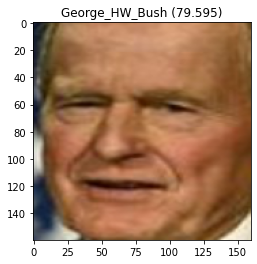

In [57]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


# load faces
data = load('dataset.npz')
testX_faces = data['arr_2']

# load face embeddings
data = load('dataset-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True, random_state=0)
model.fit(trainX, trainy)

# save the model to disk
filename = 'svc4.sav'
joblib.dump(model, filename)

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

Predicted: George_HW_Bush (79.595)
Expected: George_HW_Bush


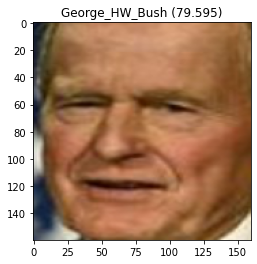

Predicted: George_HW_Bush (73.566)
Expected: George_HW_Bush


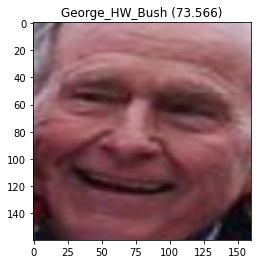

Predicted: George_HW_Bush (74.917)
Expected: George_HW_Bush


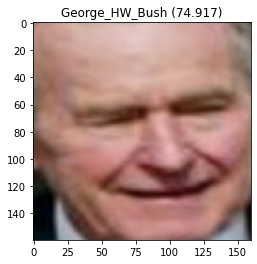

Predicted: Jose_Luis (52.278)
Expected: Jose_Luis


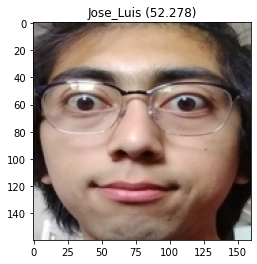

Predicted: Jose_Luis (60.403)
Expected: Jose_Luis


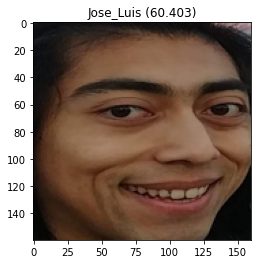

Predicted: Jose_Luis (62.898)
Expected: Jose_Luis


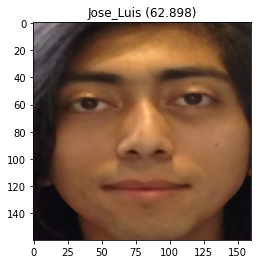

Predicted: Leonardo_DiCaprio (69.003)
Expected: Leonardo_DiCaprio


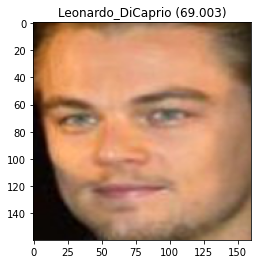

Predicted: Leonardo_DiCaprio (56.506)
Expected: Leonardo_DiCaprio


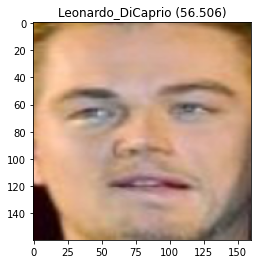

Predicted: Meryl_Streep (81.751)
Expected: Meryl_Streep


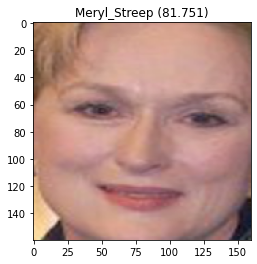

Predicted: Meryl_Streep (80.016)
Expected: Meryl_Streep


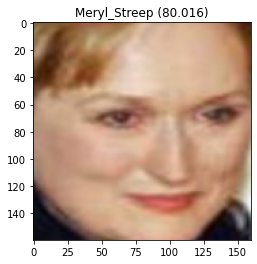

Predicted: Meryl_Streep (59.126)
Expected: Meryl_Streep


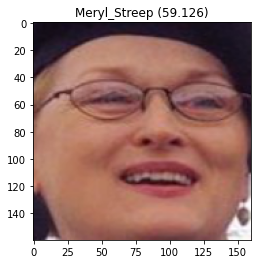

Predicted: Michael_Jackson (76.423)
Expected: Michael_Jackson


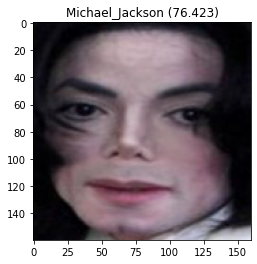

Predicted: Michael_Jackson (73.319)
Expected: Michael_Jackson


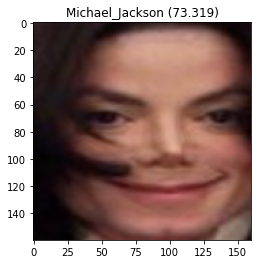

Predicted: Michael_Jackson (70.319)
Expected: Michael_Jackson


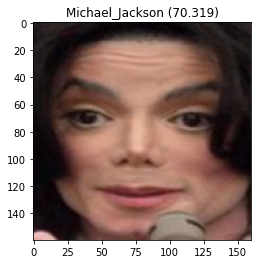

Predicted: Patricia (56.505)
Expected: Patricia


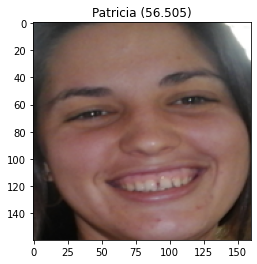

Predicted: Patricia (60.059)
Expected: Patricia


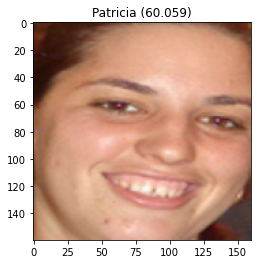

Predicted: Patricia (50.749)
Expected: Patricia


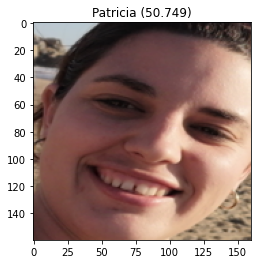

Predicted: Unknown (84.489)
Expected: Unknown


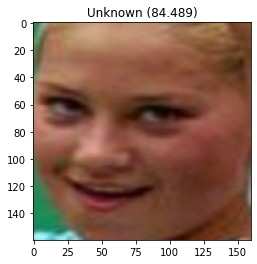

Predicted: Unknown (88.682)
Expected: Unknown


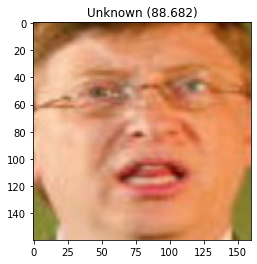

Predicted: Unknown (90.478)
Expected: Unknown


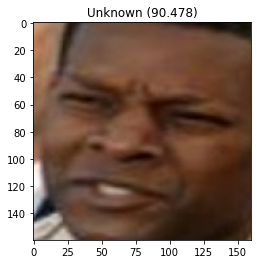

Predicted: Unknown (74.773)
Expected: Unknown


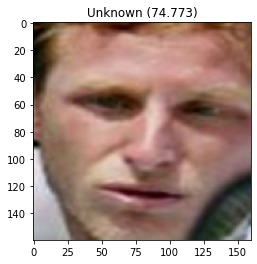

Predicted: Unknown (93.669)
Expected: Unknown


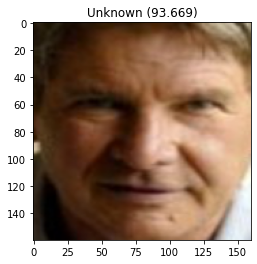

Predicted: Unknown (91.334)
Expected: Unknown


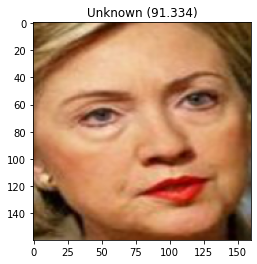

Predicted: Unknown (89.897)
Expected: Unknown


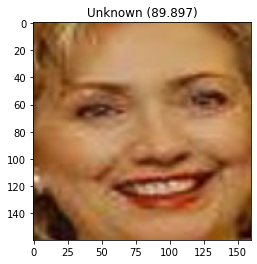

Predicted: Unknown (89.038)
Expected: Unknown


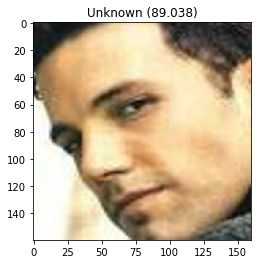

Predicted: Unknown (89.181)
Expected: Unknown


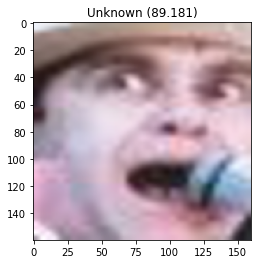

Predicted: Unknown (89.398)
Expected: Unknown


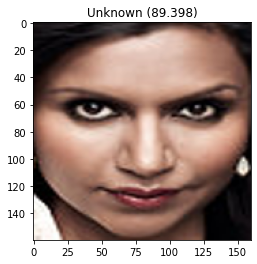

Predicted: Unknown (89.102)
Expected: Unknown


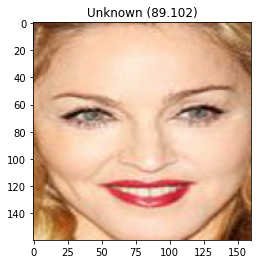

Predicted: Unknown (89.812)
Expected: Unknown


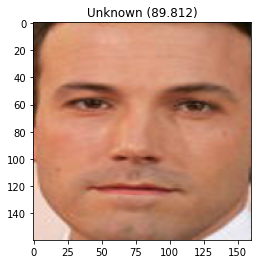

Predicted: Unknown (82.085)
Expected: Unknown


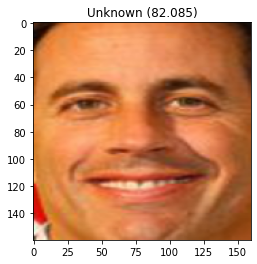

Predicted: Unknown (93.633)
Expected: Unknown


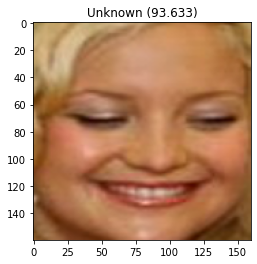

Predicted: Unknown (91.052)
Expected: Unknown


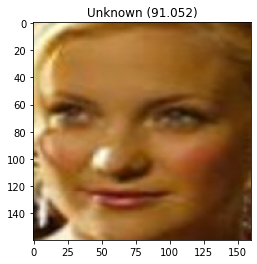

Predicted: Unknown (90.050)
Expected: Unknown


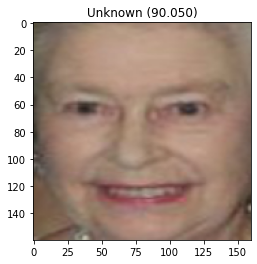

Predicted: Unknown (85.595)
Expected: Unknown


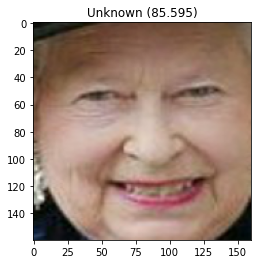

Predicted: Unknown (84.389)
Expected: Unknown


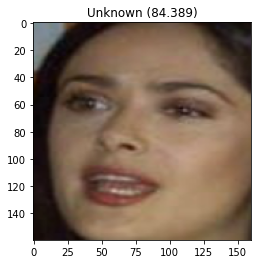

Predicted: Unknown (82.862)
Expected: Unknown


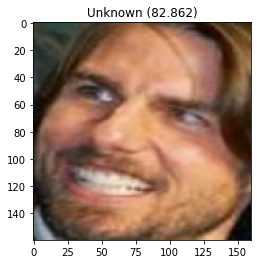

Predicted: Unknown (89.827)
Expected: Unknown


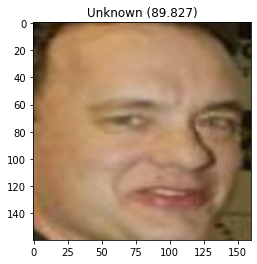

Predicted: Unknown (88.919)
Expected: Unknown


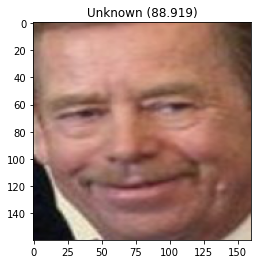

Predicted: Unknown (86.519)
Expected: Unknown


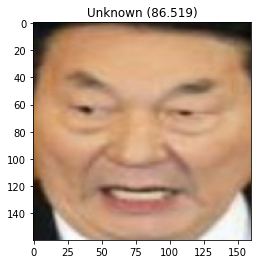

In [58]:
#Define True Positive (TP) and False Positive (FP)
TP = []
FP = []

#Store predicted classes and probabilities
prediction = []
probabilities = []
classes = []

# Predict every face in the test set and compare with the expected label
for i in range(len(testX_faces)):
    face_pixels = testX_faces[i]
    face_emb = testX[i]
    face_class = testy[i]
    face_name = out_encoder.inverse_transform([testy[i]])
    
    # prediction for the face
    #sample = expand_dims(testX[i], axis=0)
    sample = face_emb.reshape(1, 128)
    yhat_class = model.predict(sample)
    prediction.append(yhat_class)
    yhat_prob = model.predict_proba(sample)
    probabilities.append(yhat_prob)
    
    #Compare with expected label
    if yhat_class == face_class:
        TP.append(i)
    else:
        FP.append(i)
        
     # get name
    all_class_index = yhat_class[0]
    all_class_probability = yhat_prob[0,all_class_index] * 100
    predict_all_names = out_encoder.inverse_transform(yhat_class)
    classes.append(predict_all_names)
    print('Predicted: %s (%.3f)' % (predict_all_names[0], all_class_probability))
    print('Expected: %s' % face_name[0])

    # plot for fun
    pyplot.imshow(face_pixels)
    title_2 = '%s (%.3f)' % (predict_all_names[0], all_class_probability)
    pyplot.title(title_2)
    pyplot.show()
    
with open('labels2_lfw.txt', 'wb') as fp:
    pickle.dump(prediction, fp)

System accuracy
Correctly classify: 100.0%
Incorrectly classify: 0.0%


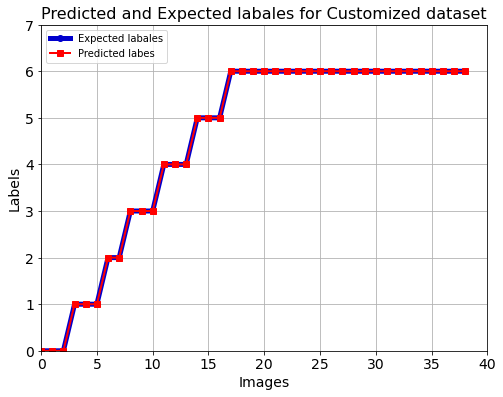

In [60]:
import matplotlib.pyplot as plt

#Metrics
TP_perc = (len(TP)/len(testX_faces))*100
FP_perc = (len(FP)/len(testX_faces))*100
X = float(TP_perc)
Y = float(FP_perc)
TPR  = round(X, 2)
FPR  = round(Y, 2)

print('System accuracy')
print('Correctly classify: %s' % (TPR) + '%')
print('Incorrectly classify: %s' % (FPR) + '%') 

#Plotting labels
f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax1.plot(testy, color="mediumblue", linestyle="-", marker="o", linewidth=5, label="Expected labales")
ax1.plot(prediction, color="r", linestyle="-", marker="s", linewidth=2, label="Predicted labes")

ax1.set_title('Predicted and Expected labales for Customized dataset', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper left')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Images', fontsize=14)
plt.ylabel('Labels', fontsize=14)
plt.xlim(0, 40)
plt.ylim(0, 7)
plt.grid(b=None, which='major', axis='both')
plt.savefig('predicted vs. expected-dataset.png')
plt.show()

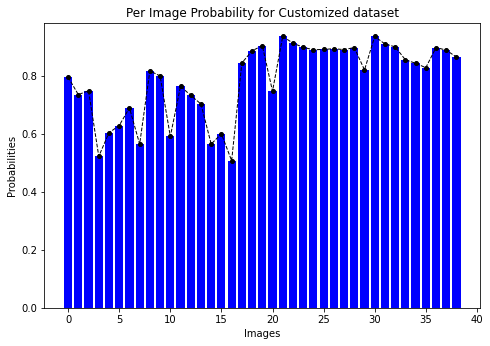

In [61]:
prob = []
for i in probabilities:
    prob.append(max(max(i)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

labels = []
for i in range(len(prob)):
    if testy[i] != testy[i-1]:
        labels.append(classes[i][0])
        
ax.set_xlabel("Images")
ax.set_ylabel('Probabilities')
ax.set_title("Per Image Probability for Customized dataset")

colors = np.random.rand(len(labels),3)

for i in range(len(prob)):
    ax.bar(i, prob[i], color='b')
#plt.xticks(range(len(prob)), range(len(prob)), fontsize=5, rotation=0)
ax.plot(range(len(prob)), prob[0:], color='black', marker='o', linestyle='dashed', linewidth = 1, markersize = 4)
fig.tight_layout(pad=5) 

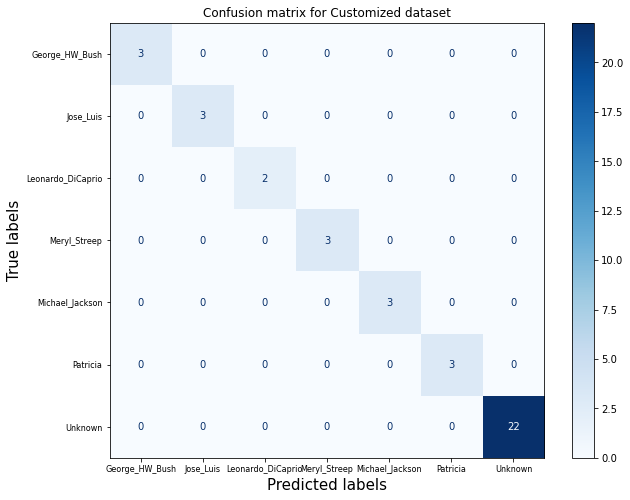

In [62]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
C = plot_confusion_matrix(model, testX, testy, display_labels = labels, xticks_rotation = 0, cmap=plt.cm.Blues, ax = ax)
                  
C.ax_.set_title("Confusion matrix for Customized dataset")
ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)
    #print(title)
   # print(C.confusion_matrix)

plt.show()

In [64]:
# Write labels in txt file for future inference
import pickle

newlist = []
newlist2= []
newlist3 = []

for i in range(len(prediction)):
    if prediction[i][0] != prediction[i-1][0]:
        newlist.append(prediction[i][0])
        
for i in range(len(newlist)):
    a = np.asarray(newlist[i])
    b = expand_dims(a, axis=0)
    #print(b.shape)
    c = out_encoder.inverse_transform(b)
    newlist2.append(c)

for i in range(len(newlist2)):
    newlist3.append(newlist2[i][0])

# Save to txt 
with open('labels_dataset_svm.txt', 'wb') as fp:
    pickle.dump(newlist3, fp)

with open('labels_code_dataset_svm.txt', 'wb') as fp:
    pickle.dump(newlist, fp)
    
# Check if they were properly saved
with open ('labels_dataset_svm.txt', 'rb') as fp:
    itemlist2 = pickle.load(fp)

with open ('labels_code_dataset_svm.txt', 'rb') as fp:
    itemlist3 = pickle.load(fp)

for i in range(len(newlist)):
    print(itemlist2[i])
    print(itemlist3[i])

George_HW_Bush
0
Jose_Luis
1
Leonardo_DiCaprio
2
Meryl_Streep
3
Michael_Jackson
4
Patricia
5
Unknown
6
